<a href="https://colab.research.google.com/github/paul-kim88/pythonProject2/blob/master/homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/gdrive


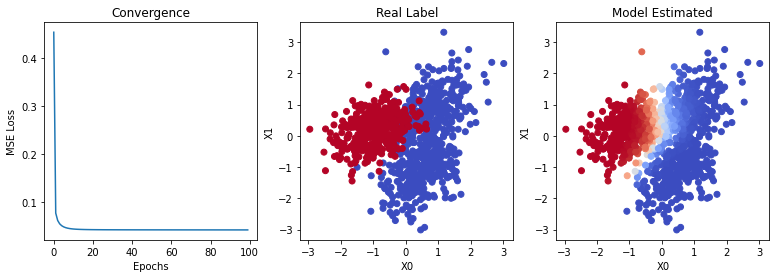

In [1]:
# Stochastic Gradient Descent
class SGD:
  def __init__(self, learning_rate=0.01):
    self.learning_rate = learning_rate

  def update(self, params, grads):
    for key in params.keys():
      params[key] -= self.learning_rate * grads[key]

# Sigmoid Layer 
class Sigmoid:
  def __init__(self):
    self.out=None

  def forward(self, x):
    self.out = 1 / (1+ np.exp(-x))
    return self.out

  def backward(self, dout):
    dx = dout * (1.0 - self.out) * self.out
    return dx

# ReLU Layer
class ReLU:
  def __init__(self):
    self.out = None

  def forward(self, x):
    self.mask = (x<0)
    out = x.copy()
    out[x<0] = 0
    return out
  
  def backward(self, dout):
    dout[self.mask] = 0
    dx = dout
    return dx

# MSE Loss Calculation
class MSE:
  def __init__(self):
    self.y = None
    self.t = None
    self.loss = None
  
  def forward(self,y,t):
    self.y = y
    self.t = t
    self.loss = np.mean((y-t)**2)
    return self.loss
  
  def backward(self, dout=1):
    return 2*(self.y-self.t)

# Perceptron
class Layer:

  def __init__(self, W):
    self.W = W
    self.input_data = None
    self.input_data_shape = None
    self.dW = None
 
  def forward(self, input_data):
    self.input_data_shape = input_data.shape
    input_data = input_data.reshape(input_data.shape[0], -1)
    self.input_data = input_data
    out = np.dot(self.input_data, self.W)
    return out
  
  def backward(self, dout):
    dx = np.dot(dout, self.W.T)
    self.dW = np.dot(self.input_data.T , dout)
    dx = dx.reshape(*self.input_data_shape)
    return dx

# Neural Network without bias
class NN:
  def __init__(self, input_size, hidden_size_list, output_size):
    self.input_size = input_size
    self.hidden_size_list = hidden_size_list
    self.hidden_layer_num = len(hidden_size_list)
    self.output_size = output_size
    self.size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
    self.params = {}
    self.layers = OrderedDict()

    for i in range(1,len(self.size_list)):
      he_norm = np.sqrt(2.0 / self.size_list[i-1]) #He Normalization
      self.params['W' + str(i)] = np.random.randn(self.size_list[i-1],self.size_list[i])*he_norm
      self.layers['Layer' + str(i)] = Layer(self.params['W'+str(i)])
      self.layers['Activation' + str(i)] = Sigmoid() if i==len(self.size_list)-1 else ReLU()
    self.last_layer = MSE()
  
  def forward(self, x):
    for key, layer in self.layers.items():
      x = layer.forward(x)
    self.last_layer.forward(x,t)
    return x

  def backward(self, x, t):
    dout = self.last_layer.backward()
    backward_list = list(self.layers.values())
    backward_list.reverse()
    for layers in backward_list: #backpropagation
      dout = layers.backward(dout)
    
    grads = {}

    for i in range(1,len(self.size_list)):
      grads['W' + str(i)] = self.layers['Layer' + str(i)].dW    
    return grads

  def loss(self, x, t):
    y = self.forward(x)
    return self.last_layer.forward(y,t)


if __name__ == '__main__': 

  #Library Import

  from google.colab import drive
  import numpy as np
  import matplotlib.pyplot as plt
  from collections import OrderedDict

  #File Import - If not using Colab, change the directory

  drive.mount('/content/gdrive')
  data_file = open('/content/gdrive/MyDrive/data/training.txt')
  rawdata = data_file.read()

  #Data Preprocessing
  rawdata = rawdata.lstrip().rstrip().replace('\n',' ').split('   ')
  rawdata = np.array(rawdata,dtype=np.float32).reshape(-1,3)
  X = rawdata[:,:2]
  X = (X-X.mean(axis=0))/X.std(axis=0) #Normalization Inputs
  t = rawdata[:,2].reshape(-1,1)

  #Model Design

  model = NN(input_size = 2, hidden_size_list = [8],output_size = 1)
  epoch_num = 100
  optimizer = SGD(learning_rate=0.01)
  loss_list = []

  for i in range(epoch_num):
    loss_list.append(model.loss(X,t))
    idx = np.arange(len(X))
    np.random.shuffle(idx) #shffule Dataset

    for j in idx:
      model.loss(X[j].reshape(1,-1),t[j])
      grads=model.backward(X[j].reshape(1,-1),t[j])
      optimizer.update(model.params,grads)

  plt.figure(figsize=(13,4))
  plt.subplot(1,3,1)
  plt.plot(loss_list)
  plt.title('Convergence')
  plt.xlabel('Epochs')
  plt.ylabel('MSE Loss')

  plt.subplot(1,3,2)
  plt.scatter(X[:,0], X[:,1],c=t, cmap='coolwarm')
  plt.title('Real Label')
  plt.xlabel('X0')
  plt.ylabel('X1')

  plt.subplot(1,3,3)
  plt.scatter(X[:,0], X[:,1],c=model.forward(X), cmap='coolwarm')
  plt.title('Model Estimated')
  plt.xlabel('X0')
  plt.ylabel('X1')